<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introducción.-Downside-Measures." data-toc-modified-id="Introducción.-Downside-Measures.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introducción. Downside Measures.</a></span></li><li><span><a href="#Teoría" data-toc-modified-id="Teoría-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Teoría</a></span><ul class="toc-item"><li><span><a href="#Librerías" data-toc-modified-id="Librerías-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Librerías</a></span></li><li><span><a href="#Cargar-datos" data-toc-modified-id="Cargar-datos-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Cargar datos</a></span></li><li><span><a href="#Semi-Desviación" data-toc-modified-id="Semi-Desviación-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Semi-Desviación</a></span></li><li><span><a href="#VaR" data-toc-modified-id="VaR-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>VaR</a></span><ul class="toc-item"><li><span><a href="#Historic-VaR" data-toc-modified-id="Historic-VaR-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Historic VaR</a></span></li><li><span><a href="#Parametric-Gaussian-VaR" data-toc-modified-id="Parametric-Gaussian-VaR-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Parametric Gaussian VaR</a></span></li><li><span><a href="#Cornish-Fisher-Modification" data-toc-modified-id="Cornish-Fisher-Modification-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>Cornish-Fisher Modification</a></span></li><li><span><a href="#Comparativa" data-toc-modified-id="Comparativa-2.4.4"><span class="toc-item-num">2.4.4&nbsp;&nbsp;</span>Comparativa</a></span></li></ul></li><li><span><a href="#CVaR" data-toc-modified-id="CVaR-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>CVaR</a></span></li></ul></li></ul></div>

## Introducción. Downside Measures.

A continuación se verán en práctica las métricas de riesgo de pérdidas (a parte del drawdown visto anteriomente). Ya hemos visto cómo calcular los drawdowns, pero vamos a ver 3 medidas populares, y vamos a desarrollar código para calcularlas y añadirlas a nuestra caja de herramientas.
El código es muy sencillo:

- __Semi-Desviación.__ La volatilidad del subconjunto de rendimientos que son negativos.


- __VaR.__ Para calcular el VaR histórico a un determinado nivel, digamos el 5%, todo lo que tenemos que hacer es encontrar el número tal que el 5% de los rendimientos caen por debajo de ese número y el 95% de los rendimientos caen por encima de ese número. En otras palabras, queremos la rentabilidad del percentil 5. Se implementarán tres formas diferentes de calcular el Valor en riesgo:

    - (1) VaR histórico.
    - (2) VaR gaussiano paramétrico.
    - (3) VaR modificado (Cornish-Fisher).


- __CVaR.__ Valor de pérdida promedia sobre una probabilidad de pérdida dada. Una vez conocido el VaR, para obtener el CVaR se calcula  la media de los retornos que cayeron por debajo del VaR.


<hr style="height:5px;border-width:0;color:orange;background-color:orange">


## Teoría

### Librerías

In [1]:
import pandas as pd
import numpy as np
from modules import edhec_risk_kit as erk

# Modo desarrollo del módulo edhec_risk_kit
%load_ext autoreload
%autoreload 2

### Cargar datos

In [2]:
df_hfi = erk.get_hfi_returns(directory='../data/')
df_hfi.head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,0.0119,0.0393,0.0178,0.0791,0.0189,0.0213,0.0191,0.0573,0.0281,0.0150,0.0180,-0.0166,0.0317
1997-02,0.0123,0.0298,0.0122,0.0525,0.0101,0.0084,0.0122,0.0175,-0.0006,0.0034,0.0118,0.0426,0.0106
1997-03,0.0078,-0.0021,-0.0012,-0.0120,0.0016,-0.0023,0.0109,-0.0119,-0.0084,0.0060,0.0010,0.0778,-0.0077
1997-04,0.0086,-0.0170,0.0030,0.0119,0.0119,-0.0005,0.0130,0.0172,0.0084,-0.0001,0.0122,-0.0129,0.0009
1997-05,0.0156,-0.0015,0.0233,0.0315,0.0189,0.0346,0.0118,0.0108,0.0394,0.0197,0.0173,-0.0737,0.0275


In [3]:
df_ffme = erk.get_ffme_returns(directory='../data/')
df_ffme.head()

,SmallCap,LargeCap
1926-07,-0.0057,0.0333
1926-08,0.0384,0.0233
1926-09,-0.0048,-0.0009
1926-10,-0.0329,-0.0295
1926-11,-0.0055,0.0316


### Semi-Desviación

In [4]:
def negative_semideviation(r):
    """
    Devuelve la semidesviación en la semidesviación negativa de r
    
    Args:
    ------
    r [{pd.Series or pd.DataFrame}] -- Serie(s) temporal de retornos.
    
    Returns:
    ----------
    semideviation {[float or pd.Series]} -- Semidesviación negativa de los retornos
    """
    is_negative = r < 0
    ns = r[is_negative].std(ddof=0)
    return ns

In [5]:
# Método 1 - Función propia
erk.negative_semideviation(df_hfi).sort_values()

Global Macro              0.006579
Merger Arbitrage          0.008875
Equity Market Neutral     0.009566
Funds Of Funds            0.012122
Relative Value            0.012244
CTA Global                0.012443
Long/Short Equity         0.014051
Distressed Securities     0.015185
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Convertible Arbitrage     0.019540
Short Selling             0.027283
Emerging Markets          0.028039
dtype: float64

In [6]:
# Método 2 - numpy
df_hfi[df_hfi<0].std(ddof=0).sort_values()

Global Macro              0.006579
Merger Arbitrage          0.008875
Equity Market Neutral     0.009566
Funds Of Funds            0.012122
Relative Value            0.012244
CTA Global                0.012443
Long/Short Equity         0.014051
Distressed Securities     0.015185
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Convertible Arbitrage     0.019540
Short Selling             0.027283
Emerging Markets          0.028039
dtype: float64

In [7]:
erk.negative_semideviation(df_ffme).sort_values()

LargeCap    0.041823
SmallCap    0.052554
dtype: float64

### VaR

A efectos de información, es habitual invertir el signo del valor del VaR, de modo que se indica un número positivo para representar la __pérdida/loss__, es decir, la cantidad que está en riesgo.

#### Historic VaR

In [8]:
# Método 1 - VaR histórico
def var_historic(r, level=5):
    """
    Devuelve el Valor en Riesgo utilizando el método de histórico en un nivel 
    especificado, es decir, devuelve el número tal que el porcentaje de 
    "nivel" de los rendimientos se sitúan por debajo de ese número, y 
    el porcentaje (de nivel 100) está por encima.
    
    Args:
    r [{pd.Series or pd.DataFrame}] -- Serie(s) temporal de retornos.
    level [{float}] -- Nivel de riesgo
    
    Returns:
    ----------
    var {[float or pd.Series]} -- VaR calculado con el método de históricos.
    """
    
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    
    else:
        raise TypeError('El tipado de la serie temporal de rendimientos debe ser pandas.Series o pandas.DataFrame')

In [9]:
# Método percentil de numpy
np.percentile(df_hfi, 1, axis=0)

array([-0.031776, -0.049542, -0.046654, -0.088466, -0.018   , -0.048612,
       -0.041672, -0.024316, -0.049558, -0.025336, -0.02666 , -0.113576,
       -0.039664])

In [10]:
var_historic(df_hfi, level=1).sort_values()

Equity Market Neutral     0.018000
Global Macro              0.024316
Merger Arbitrage          0.025336
Relative Value            0.026660
Convertible Arbitrage     0.031776
Funds Of Funds            0.039664
Fixed Income Arbitrage    0.041672
Distressed Securities     0.046654
Event Driven              0.048612
CTA Global                0.049542
Long/Short Equity         0.049558
Emerging Markets          0.088466
Short Selling             0.113576
dtype: float64

#### Parametric Gaussian VaR

La idea que subyace es muy sencilla. Si un conjunto de rendimientos se distribuye normalmente, sabemos, por ejemplo, que el 50% de los rendimientos están por debajo de la media y el 50% por encima.

También sabemos que aproximadamente dos tercios (66%) de los rendimientos están dentro de una desviación estándar. Esto significa que un tercio (33%) se encuentra más allá de una desviación estándar de la media. Dado que la distribución normal es simétrica, aproximadamente una sexta parte (aproximadamente el 16%) se encuentra por debajo de una desviación estándar de la media. Por lo tanto, si conocemos la media y la desviación estándar y suponemos que los rendimientos se distribuyen normalmente, el 16% del VaR sería la media menos una desviación estándar.

En general, siempre podemos convertir un punto percentil en una puntuación z (z score, número de desviaciones estándar de la media que tiene). Por lo tanto, si podemos convertir el nivel de VaR (como el 1% o el 5%) en una puntuación z, podemos calcular el nivel de rendimiento en el que ese porcentaje de rendimientos se encuentra por debajo.

scipy.stat.norm contiene una función ppf() que hace exactamente eso. Toma un percentil como 0.05 o 0.01 y proporciona la puntuación z correspondiente a eso en la distribución normal.

Por lo tanto, z-score es el número de desviaciones estándar de la media de un punto de información. También se conoce como puntuación estándar y puede muy bien ser puesto en una curva de dispersión ordinaria. Los puntajes Z se extienden desde -3 desviaciones estándar (que se desplomarían a la izquierda más lejana de la curva) hasta +3 desviaciones estándar (que se desplomarían a la derecha más lejana de la curva de dispersión). Para utilizar un z-score, hay que conocer la media μ y además la desviación estándar de la población σ.


__Formulación z-score.__

\begin{align}
z_{score} = \frac{(x – μ)}{σ}
\end{align}


__Interpretación.__
<img src="images/z_score.png" width="400" height="400">



In [11]:
from scipy.stats import norm
norm.ppf(0.5)

0.0

In [12]:
norm.ppf(.16)

-0.994457883209753

Por lo tanto, todo lo que tenemos que hacer para estimar el VaR utilizando este método es encontrar la puntuación z correspondiente al nivel percentil, y luego añadir esa cantidad de desviaciones estándar a la media, para obtener el VaR.

In [13]:
def var_gaussian(r, level=5):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    z_score =  -(r.mean() + z*r.std(ddof=0))
    return z_score

In [14]:
erk.var_gaussian(df_hfi, level=5).sort_values()

Equity Market Neutral     0.008850
Merger Arbitrage          0.010435
Relative Value            0.013061
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Distressed Securities     0.021032
Event Driven              0.021144
Funds Of Funds            0.021292
Convertible Arbitrage     0.021691
Long/Short Equity         0.026397
CTA Global                0.034235
Emerging Markets          0.047164
Short Selling             0.080086
dtype: float64

#### Cornish-Fisher Modification

La modificación de Cornish-Fisher es un ajuste elegante y sencillo.

El z-score nos dice cuántas desviaciones estándar de la media tenemos que ir para encontrar el VaR. Si los rendimientos no son normales, sabemos que la puntuación z nos dará un número inexacto. La idea básica es que, dado que observando la asimetría y la curtosis de los datos, podemos ajustar la puntuación z hacia arriba o hacia abajo para obtener una puntuación z modificada. Por ejemplo, intuitivamente, en igualdad de condiciones, si la asimetría es negativa, reduciremos la puntuación z hacia abajo, y si la asimetría es positiva, la aumentaremos.



In [15]:
def var_cornish_fisher(r, level=5):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    # modify the Z score based on observed skewness and kurtosis
    s = erk.skewness(r)
    k = erk.kurtosis(r)
    z = (z +
            (z**2 - 1)*s/6 +
            (z**3 -3*z)*(k-3)/24 -
            (2*z**3 - 5*z)*(s**2)/36
        )
    z_cf = -(r.mean() + z*r.std(ddof=0))

    return z_cf

In [16]:
erk.var_cornish_fisher(df_hfi, level=1).sort_values()

Global Macro              0.022236
Merger Arbitrage          0.032882
Equity Market Neutral     0.040248
Relative Value            0.046398
CTA Global                0.046612
Funds Of Funds            0.050031
Long/Short Equity         0.051614
Event Driven              0.057035
Distressed Securities     0.057506
Fixed Income Arbitrage    0.060776
Convertible Arbitrage     0.100100
Short Selling             0.109810
Emerging Markets          0.127977
dtype: float64

#### Comparativa

In [17]:
df_hfi_results = pd.DataFrame(index=df_hfi.columns)

In [18]:
# Var Historic
hfi_var_historic = erk.var_historic(df_hfi, level=5).sort_values()
df_hfi_var_historic = pd.DataFrame(hfi_var_historic)
df_hfi_var_historic.columns= ['Historic']
df_hfi_results = df_hfi_results.join(df_hfi_var_historic)

In [19]:
# Var Gaussian
hfi_var_gaussian = erk.var_gaussian(df_hfi, level=5).sort_values()
df_hfi_var_gaussian = pd.DataFrame(hfi_var_gaussian)
df_hfi_var_gaussian.columns= ['Gaussian']
df_hfi_results = df_hfi_results.join(df_hfi_var_gaussian)

In [20]:
# Var Cornish-Fisher
hfi_var_cornish_fisher = erk.var_cornish_fisher(df_hfi, level=5).sort_values()
df_hfi_var_cornish_fisher = pd.DataFrame(hfi_var_cornish_fisher)
df_hfi_var_cornish_fisher.columns= ['Cornish-Fisher']
df_hfi_results = df_hfi_results.join(df_hfi_var_cornish_fisher)

In [21]:
df_hfi_results

,Historic,Gaussian,Cornish-Fisher
Convertible Arbitrage,0.01576,0.021691,0.025166
CTA Global,0.03169,0.034235,0.033094
Distressed Securities,0.01966,0.021032,0.025102
Emerging Markets,0.04247,0.047164,0.053011
Equity Market Neutral,0.00814,0.008850,0.010734
Event Driven,0.02535,0.021144,0.025516
Fixed Income Arbitrage,0.00787,0.014579,0.017881
Global Macro,0.01499,0.018766,0.013581
Long/Short Equity,0.02598,0.026397,0.027935
Merger Arbitrage,0.01047,0.010435,0.012612


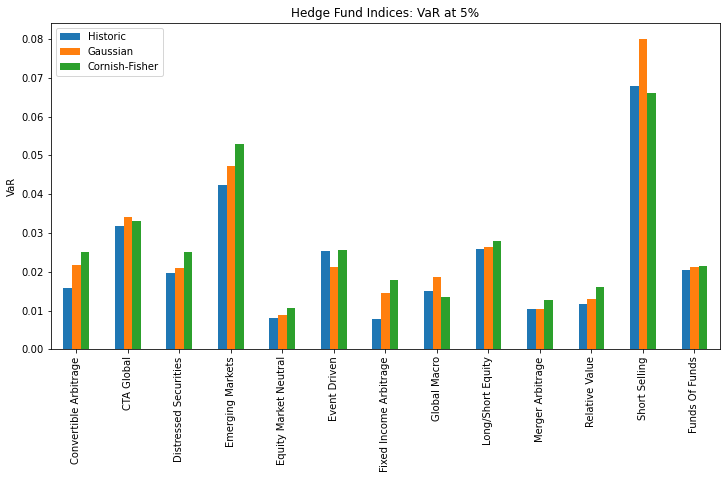

In [22]:
_ = df_hfi_results.plot.bar(title="Hedge Fund Indices: VaR at 5%", figsize=(12,6), ylabel='VaR')

Como se observa, en algunos casos, el VaR de Cornish-Fisher es inferior, es decir, estima una pérdida menor que la que se obtendría con una hipótesis gaussiana pura. Esto puede ocurrir si la asimetría observada es positiva ("Short Selling" and "Global Macro")

In [23]:
erk.skewness(df_hfi).sort_values(ascending=False)

Global Macro              0.982922
Short Selling             0.767975
CTA Global                0.173699
Funds Of Funds           -0.361783
Long/Short Equity        -0.390227
Emerging Markets         -1.167067
Distressed Securities    -1.300842
Merger Arbitrage         -1.320083
Event Driven             -1.409154
Relative Value           -1.815470
Equity Market Neutral    -2.124435
Convertible Arbitrage    -2.639592
Fixed Income Arbitrage   -3.940320
dtype: float64

### CVaR

Valor promedio de pérdidas sobre una probabilidad determinada

In [24]:
def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [25]:
def cvar_gaussian(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """     
        
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_gaussian(r, level=level)
        return -r[is_beyond].mean()
    
    
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_gaussian, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [26]:
def cvar_cornish_fisher(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """     
        
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_cornish_fisher(r, level=level)
        return -r[is_beyond].mean()
    
    
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_cornish_fisher, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [27]:
# Método 1 - Datos históricos
erk.cvar_historic(df_hfi, level=1).sort_values()

Global Macro              0.029333
Equity Market Neutral     0.036100
Merger Arbitrage          0.036233
Relative Value            0.052367
CTA Global                0.054767
Funds Of Funds            0.061133
Long/Short Equity         0.061867
Distressed Securities     0.070967
Event Driven              0.071267
Fixed Income Arbitrage    0.072467
Convertible Arbitrage     0.086100
Short Selling             0.123867
Emerging Markets          0.141167
dtype: float64

In [28]:
# Método 2 - Gaussian
erk.cvar_gaussian(df_hfi, level=1).sort_values()

Merger Arbitrage          0.027933
Equity Market Neutral     0.028060
Global Macro              0.030850
Relative Value            0.040020
Long/Short Equity         0.050571
Fixed Income Arbitrage    0.052500
CTA Global                0.054767
Distressed Securities     0.055600
Event Driven              0.057600
Funds Of Funds            0.061133
Convertible Arbitrage     0.113200
Emerging Markets          0.115100
Short Selling             0.121275
dtype: float64

In [29]:
# Método 2 - Gaussian
erk.cvar_cornish_fisher(df_hfi, level=1).sort_values()

Global Macro              0.026680
CTA Global                0.052900
Merger Arbitrage          0.054400
Equity Market Neutral     0.058700
Funds Of Funds            0.061133
Relative Value            0.061500
Long/Short Equity         0.061867
Event Driven              0.071267
Distressed Securities     0.080550
Fixed Income Arbitrage    0.083400
Convertible Arbitrage     0.113200
Short Selling             0.119160
Emerging Markets          0.162650
dtype: float64